#### SPA6330: Artificial Intelligence and Machine Learning
#### SID: 210 287 123

# MiniBooNE Event Classification

## Problem Formulation:

The MiniBooNE (Mini Booster Neutrino Experiment) [1] was a particle physics experiment at Fermilab designed to test evidence of a particular oscillation behaviour of neutrinos found by the LSND (Liquid Scintillator Neutrino Detector) experiment [2].

Neutrinos are the second most abundant particles [3]. They are nearly massless, carry no electric charge, and exist in three known flavours: electron, muon, and tau [4]. As neutrinos propagate through space, they undergo oscillations, changing flavour due to quantum mechanical mixing between flavour and mass eigenstates [5].

MinibooNE investigated these oscillations by sending a beam of mostly muon neutrinos across a distance of about 500 m [2], looking for the appearance of electron neutrinos as a signal. A big challenge was distinguishing these signals from background interactions, where muon neutrinos may be mistaken for electron neutrino events. 

Conventional analysis relied on interpreting features such as the pattern and timing of detected Cherenkov light [2] to separate signal from background. While effective, these methods leave room for improvement.

This project applies machine learning algorithms to classify neutrino events recorded by MiniBooNE [6]. The goal is to improve the separation between signal electron neutrinos and background muon neutrinos.

## Data Preparation & Feature Engineering:

In [1]:
# Importing the libraries used
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_predict, cross_validate, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import  StratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit

import zipfile
from IPython.display import display
# Library to check runtime
import time
notebook_start = time.time()

The MiniBooNE PID dataset [6] from the UC Irvine Machine Learning Repository contains neutrino events, separated into signal and background events. The data is provided as a `.txt` file. The first line specified the number of signal and background events. All subsequent lines contained 50 feature values, with signal events listed first, followed by background events.

The data was loaded into a pandas DataFrame with 50 feature columns and a target column indicating the event type. It was then shuffled to mix signal and background events randomly, preventing any ordering bias between the events.
The dataset was then saved in `.xlsx` format to facilitate easier transfer, as the original `.txt` file exceeded certain upload size limits.

The following code snippet was used to load and convert the data:

```python
# File path
with zipfile.ZipFile('miniboone+particle+identification.zip') as z:
    with z.open('MiniBooNE_PID.txt') as f: # Read the file
        lines = f.readlines()

# First line: number of signals and background events
num_signal, num_background = map(int, lines[0].strip().split())

# All other lines are data
data_lines = lines[1:]

# Check the total number of expected events
assert len(data_lines) == num_signal + num_background

# Convert each line into a list of 50 floats
data = [list(map(float, line.strip().split())) for line in data_lines]

# Create a dataframe with 50 featue columns
df = pd.DataFrame(data, columns=[f'feature_{i+1}' for i in range(50)])
df.to_excel('dataset.xlsx', index=False)
```

In [2]:
# Reading the file
df = pd.read_excel('dataset.xlsx')
# Shuffle the dataset
df = shuffle(df, random_state=10).reset_index(drop=True)

In [3]:
df.describe()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,target
count,130064.000000,130064.000000,130064.000000,130064.000000,130064.000000,130064.000000,130064.000000,130064.000000,130064.000000,130064.000000,...,130064.000000,130064.000000,130064.000000,130064.000000,130064.000000,130064.000000,130064.000000,130064.000000,130064.000000,130064.000000
mean,1.251799,-2.107551,123.795041,-3.312518,-3.585353,-3.434412,-2.627901,-2.773691,-0.155680,-3.421357,...,-25.225963,-2.863924,2.393149,-3.585605,-3.416491,-3.753232,-0.744964,-1.987056,-3.364752,0.280623
std,60.119987,59.913094,196.010686,59.834554,59.818130,59.827325,59.876644,59.866946,60.024786,59.828000,...,67.576409,59.873958,60.349468,59.818121,59.828330,59.816001,60.019330,59.946144,59.831409,0.449306
min,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,...,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000
25%,4.012528,0.876346,49.295075,0.241571,0.000000,0.085307,0.715269,0.783392,3.284817,0.142853,...,-40.068250,-0.028108,3.413030,0.000000,0.121963,-0.342814,1.420265,0.274271,0.197322,0.000000
50%,4.787715,1.381965,106.135500,0.272089,0.004975,0.141175,0.922700,0.833937,3.426990,0.170561,...,-21.591600,0.459050,4.762385,0.000000,0.168528,0.041723,2.364455,1.123760,0.231328,0.000000
75%,5.628298,1.947870,138.849250,0.315095,0.013136,0.212879,1.180252,0.874198,3.585462,0.199982,...,-3.330192,1.150463,6.857450,0.001984,0.224737,0.294544,3.777613,2.281242,0.263201,1.000000
max,17.057300,8.802820,4747.670000,0.736804,0.179012,0.703859,6.241080,0.989713,7.170170,0.524888,...,161.298000,43.651200,85.823100,0.446914,0.605667,1.932890,21.768200,25.423300,0.625484,1.000000


The dataset has 50 features and 130,064 rows of data. The features are real valued particle identification (PID) variables extracted from the reconstructed properties of neutrino interaction events [7]. They summarise information about timing, charge patterns, the properties of Cherenkov and scintillation light, and the overall event topology, as measured by photomultiplier tubes [7].

There were no nan values since the row count is the same for all columns and there were no instances of inf values. But there were some instances of missing values denoted by -999, which were many times lower than the standard deviation and lower quartile range. The number rows containing at least one -999 instance were identified. 

There were 468 rows containing at least one -999 value, out of the 130,064 total rows, making up about 0.36% of the data. Given the very small fraction, those rows were removed.

In [4]:
# Count rows where any column is -999
num_rows_with_missing = (df.iloc[:, :-1] == -999).any(axis=1).sum()
print(f"\nTotal rows with at least one -999 value: {num_rows_with_missing} / {len(df)}")

# Remove rows with any -999 values
df_clean = df[(df.iloc[:, :-1] != -999).all(axis=1)].reset_index(drop=True)
print(f"New shape after removing rows with -999: {df_clean.shape}")



Total rows with at least one -999 value: 468 / 130064
New shape after removing rows with -999: (129596, 51)


In [5]:
df_clean.describe()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,target
count,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,...,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000
mean,4.863931,1.492450,127.849703,0.283131,0.009311,0.160797,0.970221,0.823904,3.451369,0.173899,...,-21.709448,0.733346,6.009403,0.009058,0.178782,-0.159174,2.859957,1.613380,0.230708,0.281552
std,1.161277,0.860538,184.363509,0.059554,0.012493,0.122911,0.342953,0.070467,0.258654,0.043707,...,33.858218,1.224392,4.562213,0.029533,0.080407,0.977600,1.917000,1.960976,0.052818,0.449758
min,0.000000,0.059691,0.012381,0.104697,-0.156118,0.000000,0.000000,0.033510,2.375270,0.033432,...,-387.617000,-1.686500,0.249186,0.000000,0.000000,-32.109800,-13.492200,-15.997800,0.000000,0.000000
25%,4.021948,0.882372,49.978850,0.241901,0.001245,0.086348,0.717548,0.783985,3.286500,0.143172,...,-39.847675,-0.022607,3.428092,0.000000,0.122498,-0.336228,1.430775,0.281640,0.197748,0.000000
50%,4.793385,1.385640,106.423000,0.272313,0.005013,0.141468,0.924167,0.834243,3.427935,0.170756,...,-21.456250,0.462485,4.772420,0.000000,0.168888,0.043698,2.372290,1.130715,0.231553,0.000000
75%,5.632045,1.950260,138.994000,0.315312,0.013183,0.213450,1.181227,0.874354,3.586220,0.200121,...,-3.254285,1.153780,6.869710,0.002000,0.224994,0.295472,3.784865,2.286112,0.263353,1.000000
max,17.057300,8.802820,4747.670000,0.736804,0.179012,0.703859,6.241080,0.989713,7.170170,0.524888,...,161.298000,43.651200,85.823100,0.446914,0.605667,1.932890,21.768200,25.423300,0.625484,1.000000


After removing the missing values, the dataset remained large, consisting of 129,596 rows. Z-scores were computed for all features. All data points lying more than 4 standard deviations from the mean were removed. This step helped enhance model stability and training efficiency given the dataset’s size. Although this process would exclude some potentially interesting but extreme events, the primary aim of this project was to accurately classify typical signal and background events, rather than to identify rare anomalies.

The dataset was standardised by applying a scaling technique that shifts each feature to have a mean of 0 and a standard deviation of 1 [8]. Standardisation ensures that all features are on a comparable scale, preventing bias during model training [8]. It also reduces sensitivity to any remaining outliers and helps improve the efficiency and convergence speed of machine learning algorithms [8].

In [6]:
# Separate features from target
X = df_clean.drop(columns='target')
y = df_clean['target']

# Standardise the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Compute z-scores
z_scores = np.abs(zscore(X_scaled))

# Removing the outliers
# Create a mask where all feature z-scores are < threshold
mask = (z_scores < 4).all(axis=1)

# Apply mask to both features and target
X_filtered_scaled = X_scaled[mask]
y_filtered = y[mask].reset_index(drop=True)
print(f"Shape with outliers: {X.shape}")
print(f"Filtered shape: {X_filtered_scaled.shape}")

Shape with outliers: (129596, 50)
Filtered shape: (114290, 50)


To speed up experimentation and model development, a stratified shuffle split was performed to sample 30% of the cleaned dataset for training. The stratification ensures that the class distribution remained consistent with the full dataset.

In [7]:
# Stratified split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.7, random_state=10)
#df_split.get_n_splits(X_filtered_scaled, y_filtered)

for i, _ in sss.split(X_filtered_scaled, y_filtered):
    X_small = X_filtered_scaled[i]
    y_small = y_filtered.iloc[i].reset_index(drop=True)

print(f'Subset shape: {X_small.shape}')

Subset shape: (34287, 50)


The next step involved reducing the number of features to simplify the model and speed up training. To guide feature selection, Principal Component Analysis (PCA) was used. PCA is a dimensionality reduction method that transforms the original features into a new set of orthogonal components, ranked by the amount of variance they explain in the data [9].

By plotting the cumulative explained variance, the number of features that are needed to capture the majority of the dataset's variance can be determined.

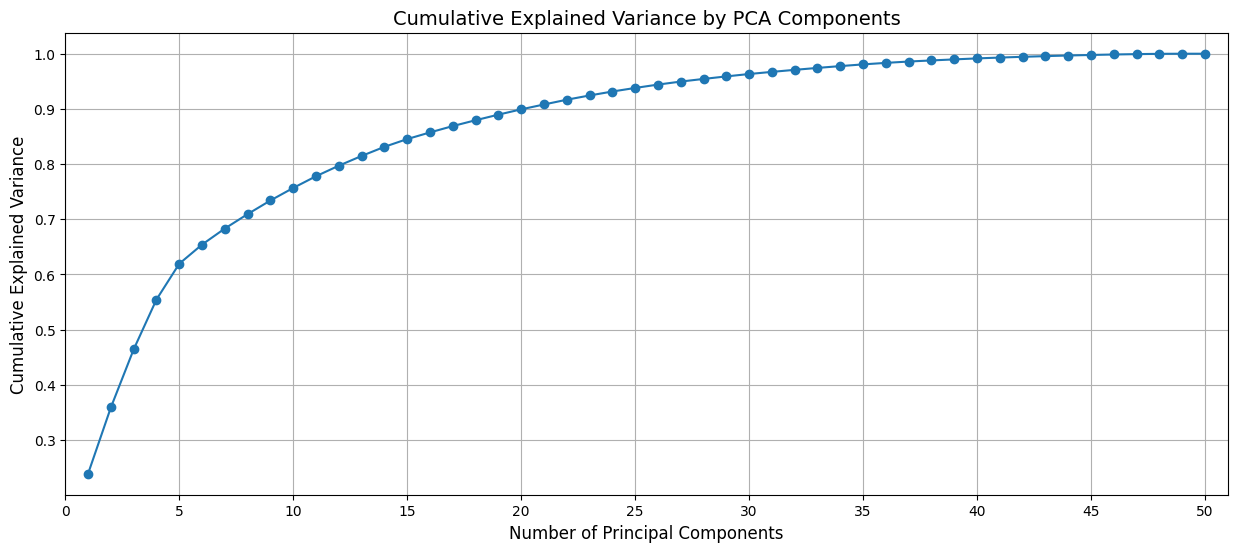

In [8]:
# Fit PCA
pca = PCA(random_state=10)
pca.fit(X_small, y_small)

# Explained variance
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

# Plot
plt.figure(figsize=(15, 6))
plt.plot(range(1, len(cumulative_var)+1), cumulative_var, marker='o')
plt.title('Cumulative Explained Variance by PCA Components', fontsize=14)
plt.xlabel('Number of Principal Components', fontsize=12)
plt.ylabel('Cumulative Explained Variance', fontsize=12)
#plt.ylim(0.95, 1.001)
plt.xticks(np.arange(0, 51, step=5))
plt.xlim(0,51)
plt.grid(True)
plt.show()

From the PCA plot, the first 21 components explain just over 90% of the total variance. Reaching a 95% cumulative variance would require approximately 28 components, and the curve flattens significantly after about 44 components.

For this project, 21 features were selected to balance sufficient variance and keeping the model lightweight and efficient.

To better understand the properties of the reduced feature set, the distributions of the 21 principal components were visualised using histograms. Examining these distributions would helped assess whether the features are approximately Gaussian, which would influence the choice of machine learning models.

In [9]:
# PCA with 21 components
pca_2 = PCA(n_components=21)
X_pca_2 = pca_2.fit_transform(X_small)

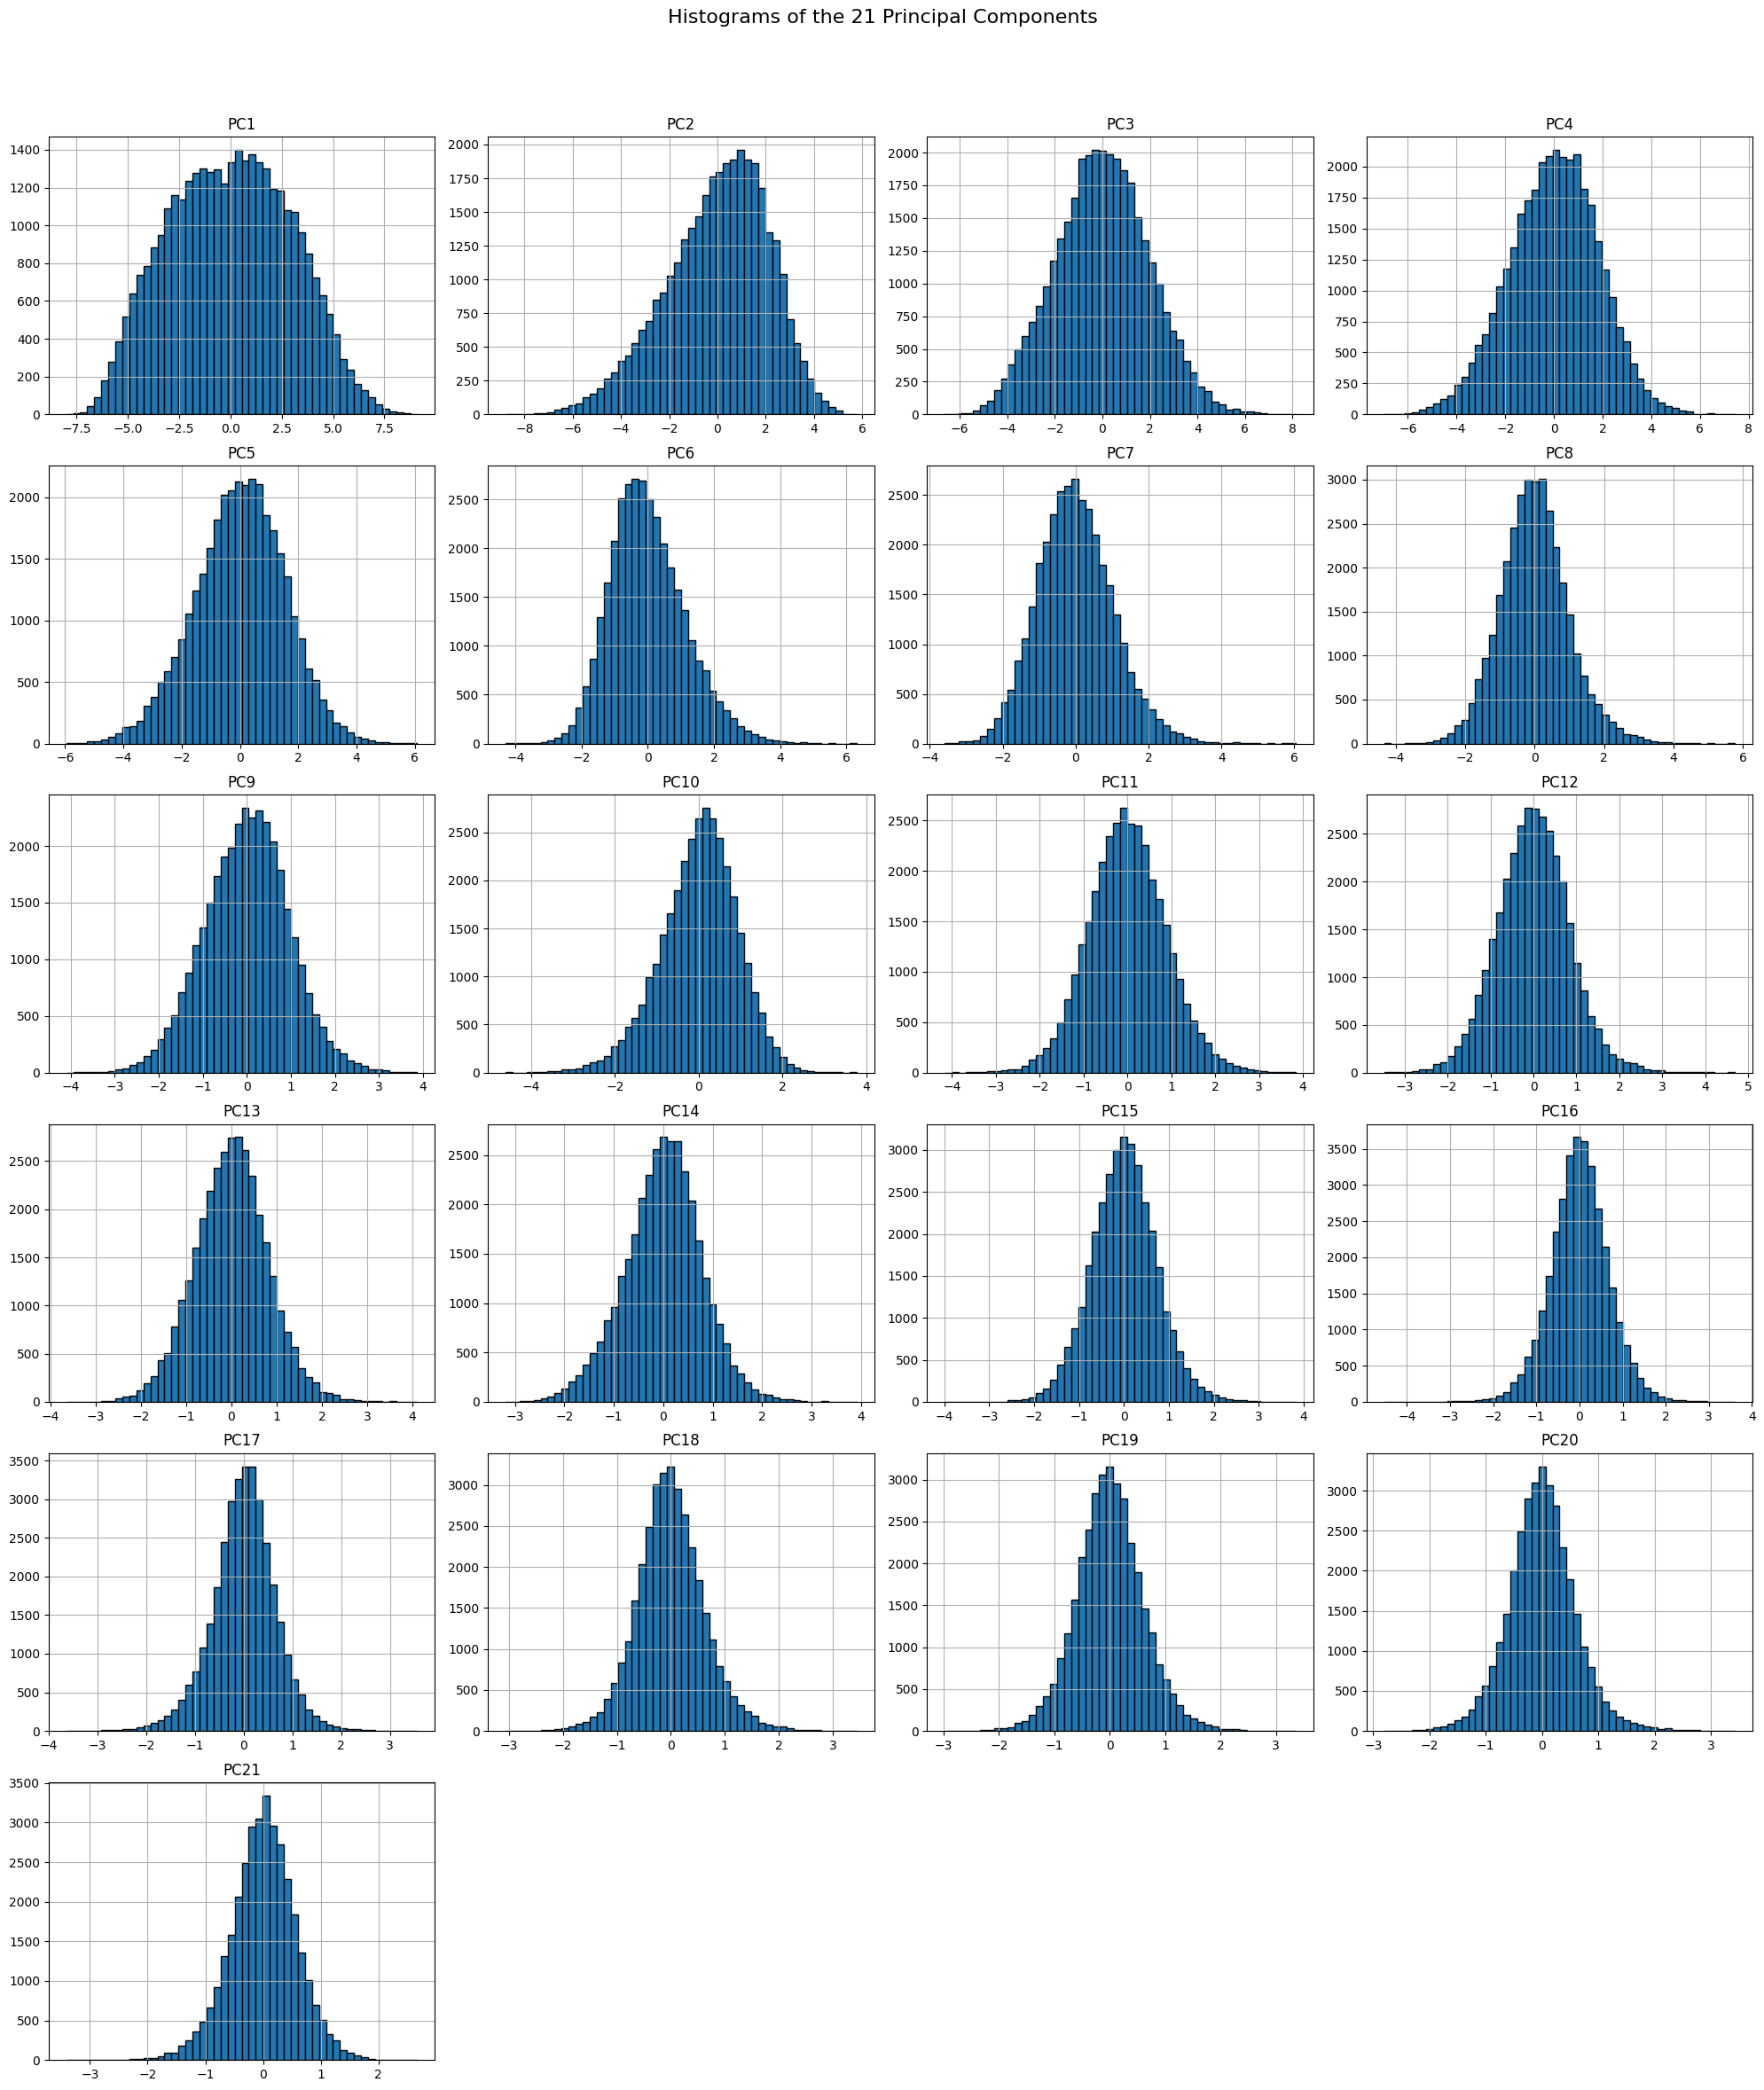

In [10]:
# Create a DataFrame for easier plotting
X_pca_df = pd.DataFrame(X_pca_2, columns=[f'PC{i+1}' for i in range(X_pca_2.shape[1])])

# Plot histogram
X_pca_df.hist(bins=50, figsize=(20, 24), layout=(6, 4), edgecolor='black')
plt.suptitle("Histograms of the 21 Principal Components", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

Most of the principal components exhibited approximately Gaussian distributions. However, PC2, PC6, PC7, PC9 and PC10 showed some skewness. 
To further explore the relationships between features, scatter plots were considered. Given the 21 components, plotting every pair would be impractical, so four features were randomly selected for closer inspection.

C:\Users\Raees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


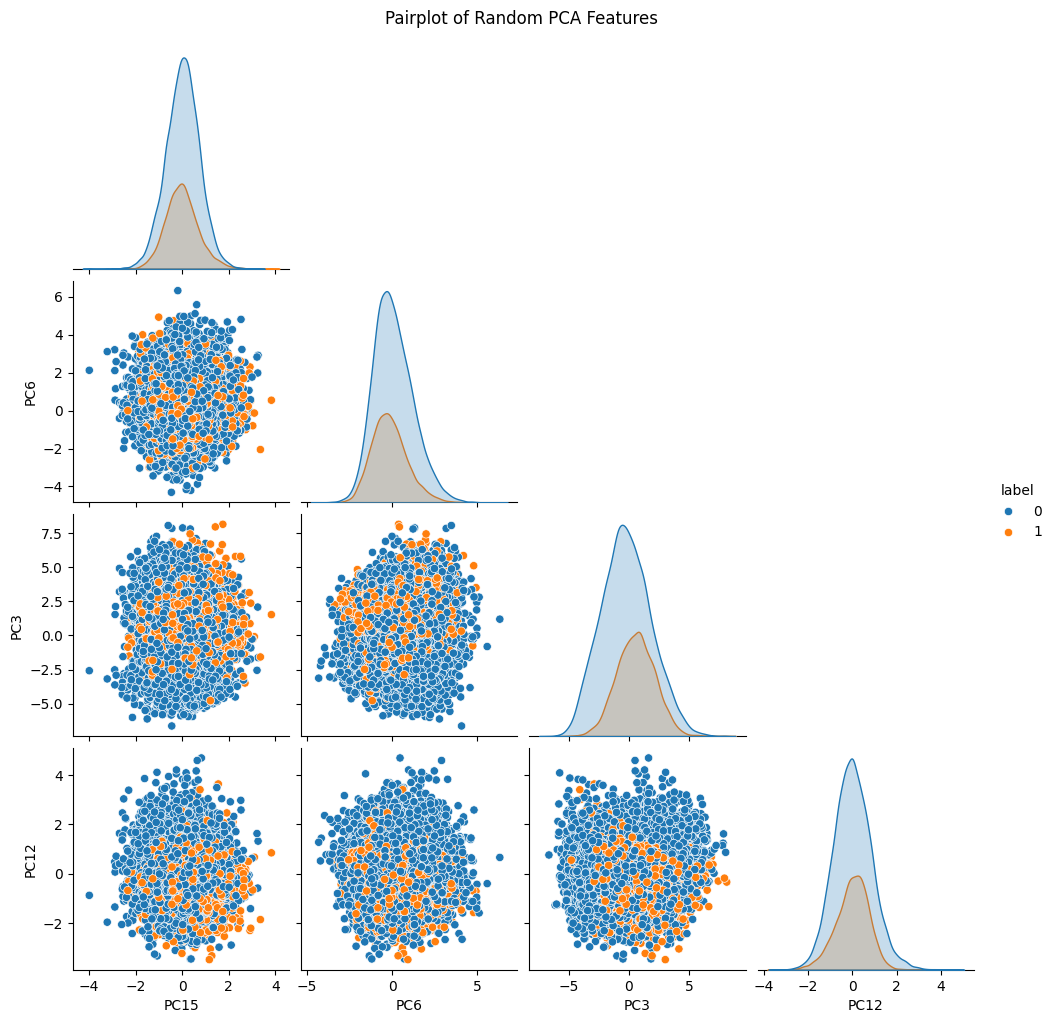

CPU times: total: 6.81 s
Wall time: 6.93 s


In [11]:
%%time
# Check the relationship of the features
# 21 features would be too much to check, so decide to select a few random ones
np.random.seed(10)
random_features = np.random.choice(X_pca_df.columns, size=4, replace=False)

# Create a small dataframe with those features and the target
plot_df = X_pca_df[random_features].copy()
plot_df['label'] = y_small.values

# Use seaborn pairplot
sns.pairplot(plot_df, hue='label', diag_kind='kde', corner=True)
plt.suptitle('Pairplot of Random PCA Features', y=1.02)
plt.tight_layout
plt.show()

The scatter plots of the randomly selected principal components revealed signs of non-linear relationships between features. This suggested that nonlinear classification models might be better suited for this dataset.

## Model Selection & Training:

A Multi-Layer Perceptron (MLP) was chosen for this project due to its flexibility and its ability to model complex, non-linear relationships present in the dataset [10]. The large dataset is well suited to MLPs, as they generally perform better with more data [11]. However, they are also computationally expensive to train and can be less interpretable than simpler models.

An MLP is a type of artificial neural network [10]. It consists of an input layer, one or more hidden layers, and an output layer [10]. Each neuron in a layer is connected to every neuron in the subsequent layer [10]. Neurons compute a weighted sum of their inputs, add a bias term, and apply a nonlinear activation function [10]. The network learns by adjusting these weights and biases to minimise prediction error over many training iterations [10].

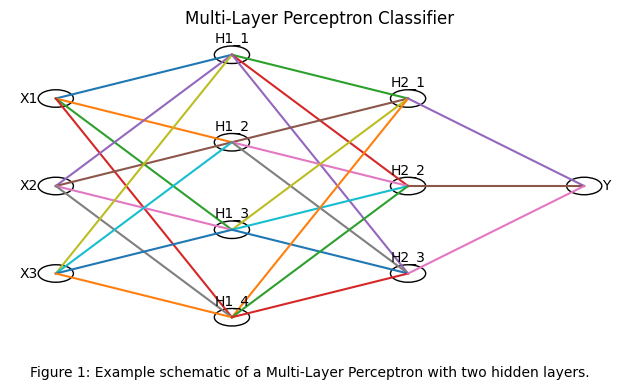

In [12]:
# Function to plot a diagram of an MLP
def draw_deep_ann():
    # Define node coordinates for each layers
    # Give input layer 3 nodes
    input_nodes = [(0, y) for y in [2, 1, 0]]
    # Give the first hidden layer 4 nodes
    hidden1_nodes = [(1, y) for y in [2.5, 1.5, 0.5, -0.5]]
    # Make a second hidden layer
    # Give it 3 nodes
    hidden2_nodes = [(2, y) for y in [2, 1, 0]]
    # Output layer with 1 node
    output_nodes = [(3, 1)]
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=(8, 4))
    
    # Draw connections from input layer to first hidden layer
    for inp in input_nodes:
        for hid in hidden1_nodes:
            ax.plot([inp[0], hid[0]], [inp[1], hid[1]])
    
    # Draw connections from first hidden layer to second hidden layer
    for hid1 in hidden1_nodes:
        for hid2 in hidden2_nodes:
            ax.plot([hid1[0], hid2[0]], [hid1[1], hid2[1]])
    
    # Draw connections from second hidden layer to output layer
    for hid2 in hidden2_nodes:
        ax.plot([hid2[0], output_nodes[0][0]], [hid2[1], output_nodes[0][1]])
    
    # Draw circles to represent the neurons at each layer
    for x, y in input_nodes + hidden1_nodes + hidden2_nodes + output_nodes:
        circle = plt.Circle((x, y), 0.1, fill=False)
        ax.add_patch(circle)
    
    # Labels
    for idx, (x, y) in enumerate(input_nodes, 1):
        ax.text(x - 0.1, y, f'X{idx}', va='center', ha='right')
    for idx, (x, y) in enumerate(hidden1_nodes, 1):
        ax.text(x, y + 0.1, f'H1_{idx}', va='bottom', ha='center')
    for idx, (x, y) in enumerate(hidden2_nodes, 1):
        ax.text(x, y + 0.1, f'H2_{idx}', va='bottom', ha='center')
    ax.text(output_nodes[0][0] + 0.1, output_nodes[0][1], 'Y', va='center', ha='left')
    fig.text(0.5, 0.01, 'Figure 1: Example schematic of a Multi-Layer Perceptron with two hidden layers.', ha='center', va='bottom', fontsize=10)
    ax.axis('off')
    plt.title('Multi-Layer Perceptron Classifier')
    plt.show()

# Call function
draw_deep_ann()

The MLPClassifier in this project is a feedforward neural network [11] with an input layer of 21 neurons and a single hidden layer of 100 neurons. 
Figure 1, shows a simplified example model with three input neurons feeding into a first hidden layer of four neurons, which in turn connects to a second hidden layer of three neurons, before reaching a single output neuron for binary classification.
Training involves minimising the cross-entropy loss using the backpropagation algorithm to compute gradients through the network [10]. Weight updates are performed using the Adam optimiser, which maintains adaptive estimates of the first and second moments of the gradients [11]. Training proceeds in mini-batches until either early stopping criteria are met or the maximum number of epochs is reached [11].

A mostly default MLPClassifer model was trained. An early stopping criterion  was enabled to terminate training if the validation score did not improve within the default tolerance, helping to prevent unnecessary training time. The dataset was split into 80% for training and 20% for testing, with stratification to preserve class balance.

In [13]:
# Spilt data (80% train, 20% test)
Xtrain, Xtest, ytrain, ytest = train_test_split(X_pca_df, y_small, test_size=0.2, random_state=10, stratify=y_small)

In [14]:
%%time
# Training model
model = MLPClassifier(early_stopping=True, random_state=10)
model.fit(Xtrain, ytrain)

CPU times: total: 1.61 s
Wall time: 1.58 s


MLPClassifier(early_stopping=True, random_state=10)

In [15]:
# Make predictions
ypred = model.predict(Xtest)

# Evaluate model
results = [{
    'Model': 'Neural Net (MLP)',
    'Accuracy': round(accuracy_score(ytest, ypred), 3),
    'Precision': round(precision_score(ytest, ypred), 3),
    'Recall': round(recall_score(ytest, ypred), 3),
}]

results_df = pd.DataFrame(results)
display(results_df)

,Model,Accuracy,Precision,Recall
0,Neural Net (MLP),0.934,0.875,0.888


The model achieved good performance on the test set, with high scores for accuracy, precision, and recall. However, to ensure that the model is not overfitting, the training set performance would also be evaluated and compared to the test results.

## Model Evaluation:

To ensure robust performance evaluation, Stratified Cross-Validation was used. Cross-validation assesses how well a machine learning model generalises to unseen data by splitting the dataset into several folds, training the model on subsets, and validating on the remaining fold [12]. This process is repeated across all folds, and the results are averaged to obtain a more stable performance estimate [12].

The Stratified Cross-Validation scores for accuracy, precision and recall were computed. A confusion matrix and Receiver Operating Characteristic (ROC) curve were plotted to further verify the model.

In [16]:
# Defining the cross-validation strategy
cv = StratifiedKFold(shuffle=True, random_state=10, n_splits=3)

In [17]:
# Perform cross-validation using the trained model and prints the metrics
def cv_metrics(model, features, target, title, cv):
    # Evaluation metrics
    scoring = ['accuracy', 'precision', 'recall']
    # Perform cross-validation
    scores = cross_validate(model, features, target, cv=cv, scoring=scoring, return_train_score=True, n_jobs=-1)

    # Prints the header
    print(f"\nCross-validation results for the {title} model:\n")
    # Loops through each metric and prints the mean and std 
    for metric in scoring:
        print(f"- Train {metric.capitalize()}: {scores[f'train_{metric}'].mean():.3f} ± {scores[f'train_{metric}'].std():.3f}")
        print(f"- Test  {metric.capitalize()}: {scores[f'test_{metric}'].mean():.3f} ± {scores[f'test_{metric}'].std():.3f}")
    print("\n")
    return
    
def cv_pred(model, features, target, cv, label_names=None, title='Model'):
    # Generate cross-validation predictions (class labels)
    ypred = cross_val_predict(model, features, target, cv=cv, n_jobs=-1)

    # Generate cross-validation predicted probabilities (for ROC)
    yproba = cross_val_predict(model, features, target, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]

    # Confusion matrix
    cm = confusion_matrix(target, ypred, labels=model.classes_)
    
    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names or model.classes_)
    disp.plot(cmap='viridis', ax=ax, values_format='d')
    plt.title(f'Confusion Matrix (Cross-Val) - {title}', fontsize=14)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(target, yproba)
    auc_score = roc_auc_score(target, yproba)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.3f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {title}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print confusion matrix summary
    tn, fp, fn, tp = cm.ravel()
    print(f"""
Summary for {title} model:
- Predicted Positives: {np.sum(ypred):,}
- True Negatives: {tn:,}
- True Positives: {tp:,}
- False Negatives: {fn:,}
- False Positives: {fp:,}
- ROC AUC Score: {auc_score:.3f}
""")



Cross-validation results for the MLPClassifier model:

- Train Accuracy: 0.939 ± 0.006
- Test  Accuracy: 0.933 ± 0.001
- Train Precision: 0.884 ± 0.012
- Test  Precision: 0.873 ± 0.001
- Train Recall: 0.899 ± 0.011
- Test  Recall: 0.885 ± 0.004




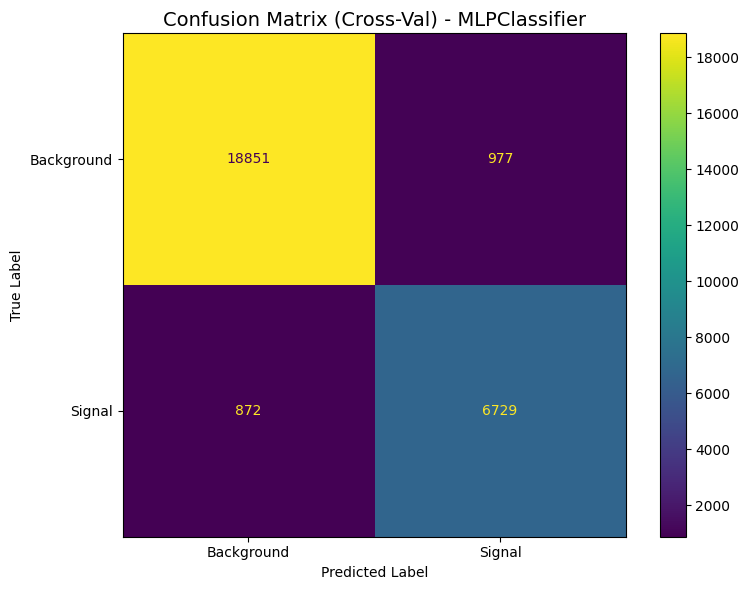

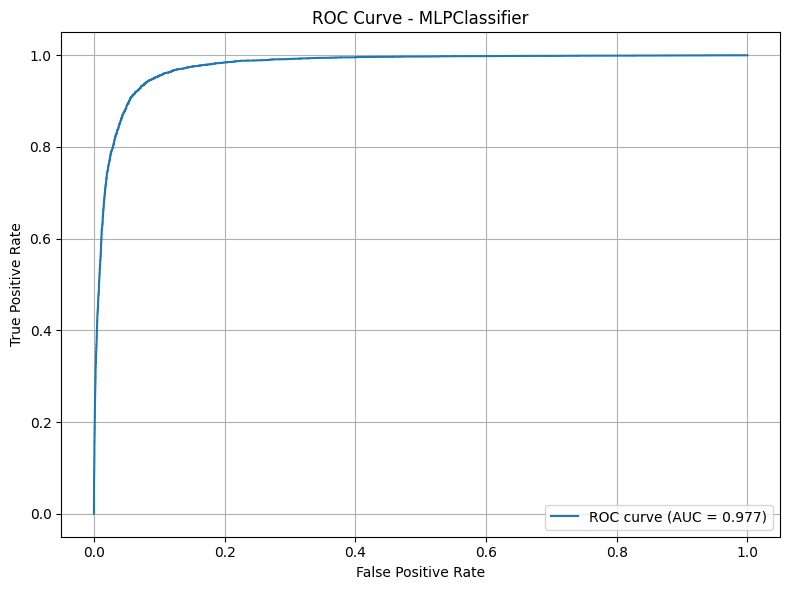


Summary for MLPClassifier model:
- Predicted Positives: 7,706
- True Negatives: 18,851
- True Positives: 6,729
- False Negatives: 872
- False Positives: 977
- ROC AUC Score: 0.977

CPU times: total: 344 ms
Wall time: 5.72 s


In [18]:
%%time
# call functions
cv_metrics(model, Xtrain, ytrain, 'MLPClassifier', cv)
cv_pred(model, Xtrain, ytrain, cv=cv, label_names=['Background', 'Signal'], title='MLPClassifier')

Overall, the model performed very well, showing high accuracy, precision, and recall, with strong generalisation to unseen data as indicated by the small gap between training and test scores. The ROC curve hugs the top left corner of the plot, indicating excellent classification performance, while the high AUC value of 0.977 further confirms the model's ability to effectively separate signal and background events.

## Model Tuning:

Since the initial model already achieved strong performance, further improvements could be challenging. To better understand the model’s learning behavior, learning curves were generated. Learning curves plot the model's performance on both the training and validation sets as a function of the training dataset size [12]. They help diagnose issues such as underfitting, overfitting, or the need for more data, and provide insight into whether the model would benefit from additional training examples or increased complexity [12].

Due to time constraints, only the learning curves for precision and recall were plotted, while the accuracy curve was omitted as it was considered less critical for this analysis.

In [19]:
# Function to plot learning curves and print metric scores 
def plot_learning_curve(model, features, target, cv, title1, scorings=['precision', 'recall'], train_sizes=np.linspace(0.2, 1.0, 4)):
    # Set up the figure
    fig, axes = plt.subplots(len(scorings), 1, figsize=(8, 4 * len(scorings)))
    all_metrics = "" # define an empty string to use later

    # Loops for the 2 scorings
    for i, score in enumerate(scorings):
        train_sizes_out, train_scores, test_scores = learning_curve(
            estimator=model,
            X=features,
            y=target,
            cv=cv,
            scoring=score,
            train_sizes=train_sizes,
            n_jobs=-1
        )

        # Calculate means and stds
        train_mean = train_scores.mean(axis=1)
        test_mean = test_scores.mean(axis=1)
        train_std = train_scores.std(axis=1)
        test_std = test_scores.std(axis=1)

        # Metrics summary
        all_metrics += (
            f'\n- {score.capitalize()}:\n'
            f'  - Train: {train_mean.mean():.3f} ± {train_std.mean():.3f}\n'
            f'  - Test : {test_mean.mean():.3f} ± {test_std.mean():.3f}\n'
        )

        # Plotting
        ax = axes[i] if len(scorings) > 1 else axes
        ax.plot(train_sizes_out, train_mean, label='Training Score', lw=2)
        ax.plot(train_sizes_out, test_mean, label='Validation Score', lw=2)
        ax.fill_between(train_sizes_out, train_mean - train_std, train_mean + train_std, alpha=0.2)
        ax.fill_between(train_sizes_out, test_mean - test_std, test_mean + test_std, alpha=0.2)
        # labelling
        ax.set_title(f'Learning Curve – {score.capitalize()}', fontsize=12)
        ax.set_xlabel('Training Size')
        ax.set_ylabel(f'{score.capitalize()} Score')
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.6)

    fig.suptitle(f'Learning Curves for {title1}', fontsize=16, weight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    print(f"Average CV Scores for {title1}:\n{all_metrics}")     

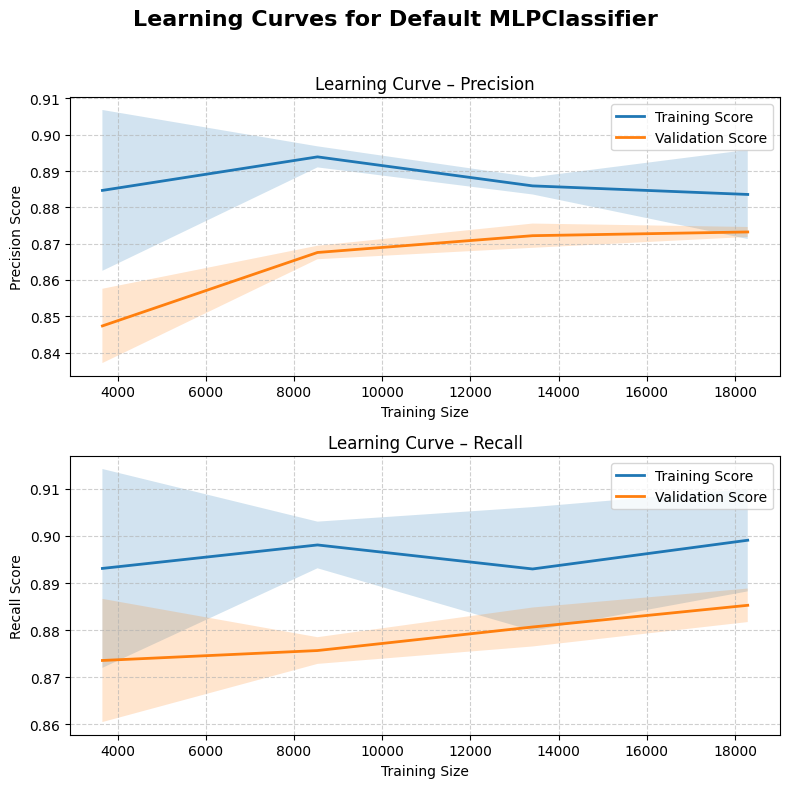

Average CV Scores for Default MLPClassifier:

- Precision:
  - Train: 0.887 ± 0.010
  - Test : 0.865 ± 0.004

- Recall:
  - Train: 0.896 ± 0.013
  - Test : 0.879 ± 0.006

CPU times: total: 281 ms
Wall time: 3.29 s


In [20]:
%%time
# Calling function
plot_learning_curve(model, Xtrain, ytrain, cv, title1='Default MLPClassifier')

The learning curves for both precision and recall indicated that the model performed well without major signs of underfitting or overfitting.  Training scores were consistently high, and validation scores were only slightly lower, suggesting good generalisation to unseen data. As the training size increased, the small gap between training and validation scores gradually narrowed, which is a desirable pattern.

In [21]:
# Checking the parameters used in the MLPClassifier
model.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': True,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 10,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

The MLPClassifier model allowed for several hyperparameters. The following were optimised using RandomizedSearchCV [11]:

- hidden_layer_sizes: Defines the number and size of hidden layers in the network.
- activation: Specifies the activation function used in the hidden layers.
- solver: Determines the optimisation algorithm for weight updates.
- alpha: L2 regularisation term to prevent overfitting.
- learning_rate: Strategy for adjusting the learning rate during training.
- learning_rate_init: The initial learning rate for weight updates.
- batch_size: Number of samples per batch during training.
- tol: Minimum improvement threshold to continue training.
- max_iter: Maximum number of iterations for training.
- n_iter_no_change: Number of epochs with no improvement after which training will stop early.

To save time, the randomised search was conducted in advance on the selected parameters. The code for the randomised search and its output are provided below. The code was executed locally, and the output is shown as an image of the DataFrame displaying the top 20 runs, sorted by their mean test scores.

```python
param_dist = {
    'hidden_layer_sizes': [(50,), (100,), (50,50), (100,50), (100,100)],
    'activation':           ['relu', 'tanh'],
    'solver':               ['adam', 'sgd'],
    'alpha':                [1e-5, 1e-4, 1e-3, 1e-2],
    'learning_rate':        ['constant', 'adaptive'],
    'learning_rate_init':   [1e-4, 1e-3, 1e-2],
    'batch_size':           [32, 64, 128],
    'tol':                  [1e-4, 1e-3],
    'max_iter':             [200, 500, 1000],
    'early_stopping':       [True],
    'n_iter_no_change':     [10, 20]
}

search = RandomizedSearchCV(
    MLPClassifier(random_state=10),
    param_distributions=param_dist,
    n_iter=200,           
    cv=cv,
    scoring='roc_auc',   
    n_jobs=4,
    verbose=1,
    random_state=10
)
search.fit(Xtrain, ytrain)
grid_lim = pd.DataFrame(grid.cv_results_)
grid_lim[['params','mean_test_score','std_test_score','mean_fit_time']].sort_values(
by='mean_test_score', ascending=False).reset_index(drop=True).head(20)
```

Output:

![Hyperparameter Search Results](Hyperparameter_Search_Results2.png)

**Figure 2:** Top 20 RandomizedSearchCV runs ranked by mean test score.

After the randomised search, the top 20 best-performing models were examined. It was observed that many hyperparameters converged to similar values, suggesting that the search space could be narrowed. A Grid Search Cross-Validation was then conducted, focusing only on the hyperparameters that exhibited meaningful variance, for more precise fine-tuning.

In [22]:
%%time
# Hyperparameter grid used for the model
param_grid = {
    'solver':            ['adam'],
    'early_stopping':    [True],
    'n_iter_no_change':  [20],
    'tol':               [1e-4],
    'hidden_layer_sizes': [(100,50)],
    'activation':         ['tanh'],

    'alpha':              [1e-5, 1e-4],
    'learning_rate_init': [1e-4, 1e-3],
    'learning_rate':      ['constant','adaptive'],

    'batch_size':         [32],
    'max_iter':           [400],
}
# GridSearchCV to find the best hyperparameters
grid = GridSearchCV(MLPClassifier(random_state=10), param_grid, cv=cv, scoring='roc_auc', verbose=1, n_jobs=-1, refit=True)
grid.fit(Xtrain, ytrain)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
CPU times: total: 5.81 s
Wall time: 27 s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=10, shuffle=True),
             estimator=MLPClassifier(random_state=10), n_jobs=-1,
             param_grid={'activation': ['tanh'], 'alpha': [1e-05, 0.0001],
                         'batch_size': [32], 'early_stopping': [True],
                         'hidden_layer_sizes': [(100, 50)],
                         'learning_rate': ['constant', 'adaptive'],
                         'learning_rate_init': [0.0001, 0.001],
                         'max_iter': [400], 'n_iter_no_change': [20],
                         'solver': ['adam'], 'tol': [0.0001]},
             scoring='roc_auc', verbose=1)

In [23]:
# Output
print(f'Best Score: {grid.best_score_:.4f}')
print('Best Parameters:')
for param, value in grid.best_params_.items():
    print(f'  - {param}: {value}')

Best Score: 0.9793
Best Parameters:
  - activation: tanh
  - alpha: 0.0001
  - batch_size: 32
  - early_stopping: True
  - hidden_layer_sizes: (100, 50)
  - learning_rate: constant
  - learning_rate_init: 0.001
  - max_iter: 400
  - n_iter_no_change: 20
  - solver: adam
  - tol: 0.0001


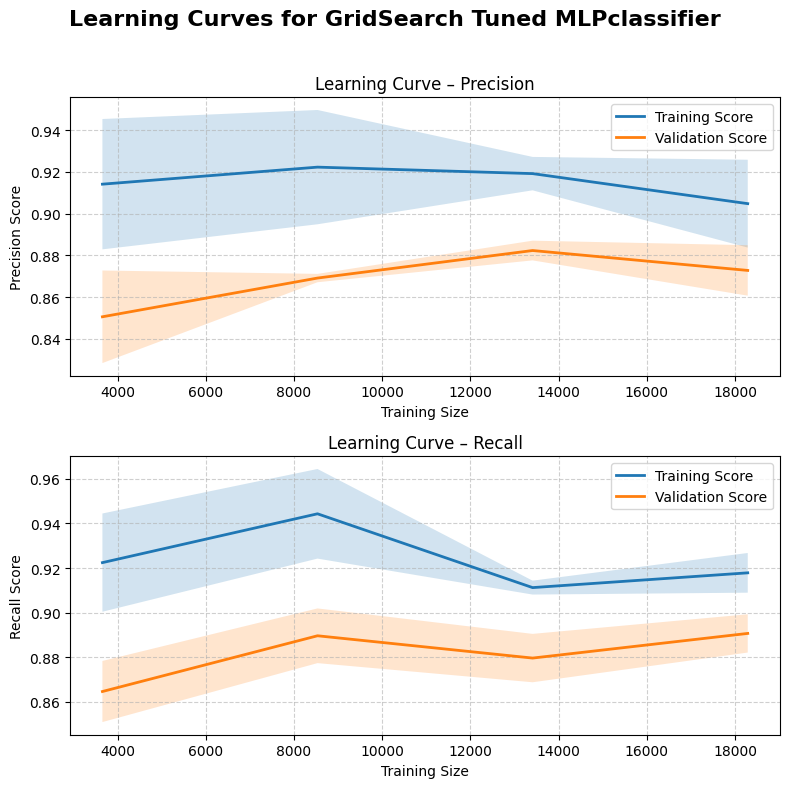

Average CV Scores for GridSearch Tuned MLPclassifier:

- Precision:
  - Train: 0.915 ± 0.022
  - Test : 0.869 ± 0.010

- Recall:
  - Train: 0.924 ± 0.014
  - Test : 0.881 ± 0.011

CPU times: total: 312 ms
Wall time: 12.6 s


In [24]:
%%time
# Calling function
plot_learning_curve(grid.best_estimator_, Xtrain, ytrain, cv, title1='GridSearch Tuned MLPclassifier')

The GridSearch tuning further confirmed that the default MLPClassifier was already performing close to optimal. While there were slight improvements in training scores, the validation scores showed only minor variation. Therefore, although the GridSearch was valuable for confirming model stability and robustness, the tuning did not significantly outperform the default configuration.

## Conclusion:

This project successfully classified signal electron neutrinos and background muon neutrinos using a MLPClassifier. The default model performed extremely well, attempts at optimisation further showed how well the default model was by only increasing model performance by a very small margin.

Given more time, several improvements could be explored to increase model performance. Increasing the training dataset size by using a larger stratified shuffled train-test split above the current 30% or by utilising the entire dataset could enable the model to capture more complex patterns and improve its generalisation capabilities.

Dimensionality reduction and feature selection strategies could also be refined. While PCA was used to retain features explaining just over 90% of the variance, increasing this threshold to 95% (28 components) or further until the PCA cumulative explained variance curve flattened (44 components) might capture more informative structure in the data. Alternatively, employing L1-based regularisation methods such as LassoCV could identify a sparse set of the most important features, offering an interpretable alternative to PCA-based dimensionality reduction.

Conducting a more extensive GridSearchCV over a wider range of parameters, including deeper networks and different learning rate strategies, could further fine-tune performance. Models such as Support Vector Classifiers could be explored, as they often perform similarly to MLPs on structured datsets.


## References:

[1] MiniBooNE Results Inconsistent with Existence of “Sterile” Neutrinos [Internet]. Aps.org. 2025 [cited 2025 Apr 28]. Available from: https://www.aps.org/archives/publications/apsnews/200706/miniboone.cfm

[2] Aguilar-Arevalo AA, Anderson CE, Bartoszek LM, Bazarko AO, Brice SJ, Brown BC, et al. The MiniBooNE detector. Nuclear Instruments and Methods in Physics Research Section A: Accelerators, Spectrometers, Detectors and Associated Equipment. 2009 Feb;599(1):28–46. 

[3] Stecker FW. Neutrino Physics and Astrophysics Overview [Internet]. arXiv.org. 2023. Available from: https://arxiv.org/abs/2301.02935

[4] What is a neutrino? | NOvA [Internet]. Available from: https://novaexperiment.fnal.gov/what-is-a-neutrino/

[5] Boyd S. Neutrino Oscillations [Internet]. 2020. Available from: https://warwick.ac.uk/fac/sci/physics/staff/academic/boyd/stuff/neutrinolectures/lec_oscillations.pdf

[6] Roe B. UCI Machine Learning Repository [Internet]. Uci.edu. 2025 [cited 2025 Apr 28]. Available from: https://archive.ics.uci.edu/dataset/199/miniboone+particle+identification

[7] Liu Y, Stancu I. Cascade training technique for particle identification. Nuclear Instruments and Methods in Physics Research Section A Accelerators Spectrometers Detectors and Associated Equipment. 2007 May 19;578(1):315–21.

[8] Cremonesi L. Week 3 - Trees and Neighbours. Queen Mary University of London: SPA6330: Artificial Intelligence & Machine Learning; 2025 Jan.

[9] Cremonesi L. Week 10 - Clustering and Dimentionality Reduction. Queen Mary University of London: SPA6330: Artificial Intelligence & Machine Learning; 2025 Mar.

[10] Booth A. Week 11: Introduction to Neural Networks. Queen Mary University of London: SPA6330: Artificial Intelligence & Machine Learning; 2025 Apr.

[11] scikit-learn. sklearn.neural_network.MLPClassifier — scikit-learn 0.20.3 documentation [Internet]. Scikit-learn.org. 2010. Available from: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

[12] Cremonesi L. Week 4 - Evaluation and Diagnostics. Queen Mary University of London: SPA6330: Artificial Intelligence & Machine Learning; 2025 Feb.

## Word Count:

The cell below outputs the total word count.

In [25]:
import io
import nbformat

filepath_2 = 'FinalProject_2025.ipynb'

with io.open(filepath_2, 'r', encoding='utf-8') as f:
    nb = nbformat.read(f, as_version=4)

word_count = 0

for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print("The total word count is:", word_count)

notebook_end = time.time()
print(f"\nTotal notebook runtime: {notebook_end - notebook_start:.2f} seconds")

The total word count is: 2601

Total notebook runtime: 94.71 seconds
